In [1]:
%matplotlib inline
import h5py
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

## Estimation of burned area from GFED4 database
The GFED4 database tracks fire activity globally on an areal and carbon basis. The data were downloaded from this URL:
https://www.geo.vu.nl/~gwerf/GFED/GFED4

A useful (though somewhat incomplete) README file is available here: 
https://www.geo.vu.nl/~gwerf/GFED/GFED4/Readme.pdf

In [2]:
def calc_monthly_burned_areas(hdf_file):
    """Returns total burned area in m^2 units for each month."""
    # Need to know the area of each cell. units of m^2
    cell_areas = f['ancill']['grid_cell_area'][:]
    burned_area_data = f['burned_area']
    monthly_burned_area = []

    # months are always in chronological order
    for month in burned_area_data.keys():
        monthly_data = burned_area_data.get(month)
        burned_fraction = monthly_data['burned_fraction'][:]
        monthly_burned_area.append((burned_fraction*cell_areas).sum())
        
    return monthly_burned_area

def calc_monthly_emissions(hdf_file):
    """Returns total co2 emissions area g C/month for each month."""
    # Need to know the area of each cell. units of m^2
    cell_areas = f['ancill']['grid_cell_area'][:]
    burned_area_data = f['emissions']
    monthly_co2_emissions = []
    monthly_dm_emissions = []
    monthly_forest_co2_emissions = []
    monthly_forest_dm_emissions = []

    # months are always in chronological order
    for month in burned_area_data.keys():
        monthly_data = burned_area_data.get(month)
        co2_emissions = monthly_data['C'][:]
        dm_emissions = monthly_data['DM'][:]
        
        # neglect tropical fires since they are categorized as human-caused. 
        boreal_fraction_C = monthly_data['partitioning']['C_BORF'][:]
        temperate_fraction_C = monthly_data['partitioning']['C_TEMF'][:]
        forest_fraction_C = boreal_fraction_C + temperate_fraction_C
        
        boreal_fraction_DM = monthly_data['partitioning']['DM_BORF'][:]
        temperate_fraction_DM = monthly_data['partitioning']['DM_TEMF'][:]
        forest_fraction_DM = boreal_fraction_DM + temperate_fraction_DM
        
        forest_co2 = forest_fraction_C*co2_emissions
        forest_dm = forest_fraction_DM*dm_emissions
        
        monthly_co2_emissions.append((co2_emissions*cell_areas).sum())
        monthly_dm_emissions.append((dm_emissions*cell_areas).sum())
        
        monthly_forest_co2_emissions.append((forest_co2*cell_areas).sum())
        monthly_forest_dm_emissions.append((forest_dm*cell_areas).sum())
        
    return monthly_co2_emissions, monthly_dm_emissions, monthly_forest_co2_emissions, monthly_forest_dm_emissions

In [3]:
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
types = {''}
years = np.arange(1997, 2007)
month_col = []
year_col = []
burned_col = []
emissions_co2_col = []
emissions_dm_col = []
forest_emissions_co2_col = []
forest_emissions_dm_col = []
total_emissions_col = []
total_forest_emissions_col = []

for year in years:
    fname = 'data/GFED4/GFED4.1s_%d.hdf5' % year
    print('Processing', fname)
    f = h5py.File(fname, mode='r')
    areas_m2 = calc_monthly_burned_areas(f)
    emissions_gC, emissions_kgDM, forest_emissions_gC, forest_emissions_kgDM = calc_monthly_emissions(f)
    emissions_gDM = (np.array(emissions_kgDM) * 1000)
    forest_emissions_gDM = (np.array(forest_emissions_kgDM) * 1000)
    
    month_col.extend(months)
    year_col.extend(12*[str(year)])
    burned_col.extend(areas_m2)
    emissions_co2_col.extend(emissions_gC)
    emissions_dm_col.extend(emissions_gDM.tolist())
    
    forest_emissions_co2_col.extend(forest_emissions_gC)
    forest_emissions_dm_col.extend(forest_emissions_gDM.tolist())
    
    # Dry biomass is about 50% carbon by mass.
    # TODO: find good ref for this. 
    total_emissions_gC = np.array(emissions_gC) + (emissions_gDM * 0.5)
    total_emissions_col.extend(total_emissions_gC.tolist())
    
    total_forest_emissions_gC = np.array(forest_emissions_gC) + (forest_emissions_gDM * 0.5)
    total_forest_emissions_col.extend(total_forest_emissions_gC.tolist())
    
data_dict = dict(month=month_col, year=year_col, area_burned_m2=burned_col,
                 emissions_gDM=emissions_dm_col, emissions_gC=emissions_dm_col,
                 total_emissions_gC=total_emissions_col,
                 forest_emissions_gDM=forest_emissions_dm_col,
                 forest_emissions_gC=forest_emissions_co2_col,
                 total_forest_emissions_gC=total_forest_emissions_col)
burned_area_df = pd.DataFrame(data_dict)

# 1 hectare is 100x100 m = 1e4 m^2.
# 1 km^2 is (1e3 m)^2 = 1e6 m^2
burned_area_df['area_burned_ha'] = burned_area_df.area_burned_m2 / 10000
burned_area_df['area_burned_km2'] = burned_area_df.area_burned_m2 / 1e6
burned_area_df['total_emissions_kgC'] = burned_area_df.total_emissions_gC / 1000
burned_area_df['total_emissions_TgC'] = burned_area_df.total_emissions_kgC / 1e9
burned_area_df['total_forest_emissions_kgC'] = burned_area_df.total_forest_emissions_gC / 1000
burned_area_df['total_forest_emissions_TgC'] = burned_area_df.total_forest_emissions_kgC / 1e9
burned_area_df.to_csv('data/GFED4_burned_area_m2.csv')

Processing data/GFED4/GFED4.1s_1997.hdf5
Processing data/GFED4/GFED4.1s_1998.hdf5
Processing data/GFED4/GFED4.1s_1999.hdf5
Processing data/GFED4/GFED4.1s_2000.hdf5
Processing data/GFED4/GFED4.1s_2001.hdf5
Processing data/GFED4/GFED4.1s_2002.hdf5
Processing data/GFED4/GFED4.1s_2003.hdf5
Processing data/GFED4/GFED4.1s_2004.hdf5
Processing data/GFED4/GFED4.1s_2005.hdf5
Processing data/GFED4/GFED4.1s_2006.hdf5


In [4]:
# Do a little sanity check to make sure the cell areas are in the right units.
# Make sure that the sum of all the cell areas resemlbes the area of the Earth
cell_areas = f['ancill']['grid_cell_area'][:]
print('total cell area = %.2g' % (cell_areas.sum() / 1e6))

# Calculate land area from Earth radius and 70% ocean by area.
# Checked against wikipedia properties, they match almost perfectly.
earth_r_km = 6371.0
earth_SA_km2 = 4*np.pi*earth_r_km**2
land_area_earth_km2 = earth_SA_km2*0.3
print('total area of Earth = %.2g' % earth_SA_km2)
print('total land area of Earth = %.2g' % land_area_earth_km2)

total cell area = 5.1e+08
total area of Earth = 5.1e+08
total land area of Earth = 1.5e+08


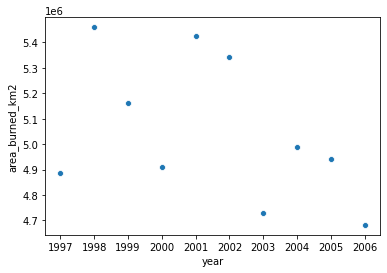

area_burned_m2                5.052901e+12
emissions_gDM                 4.742384e+15
emissions_gC                  4.742384e+15
total_emissions_gC            4.693693e+15
forest_emissions_gDM          4.578626e+14
forest_emissions_gC           2.155855e+14
total_forest_emissions_gC     4.445169e+14
area_burned_ha                5.052901e+08
area_burned_km2               5.052901e+06
total_emissions_kgC           4.693693e+12
total_emissions_TgC           4.693693e+03
total_forest_emissions_kgC    4.445169e+11
total_forest_emissions_TgC    4.445169e+02
pct_land_area_burned          3.302132e+00
dtype: float64

In [5]:
# Compare the burned area to the total land area of Earth as a sanity check. 
# Should be much less.
burned_by_year = burned_area_df.groupby('year').sum()
sns.scatterplot(data=burned_by_year, x=burned_by_year.index, y='area_burned_km2')
plt.show()

# Looks like a steady 3% of land area is burned. 
# Sanity check - NASA piece linked below claims 30% of land coverage is forest, 
# so about 10% of global forest areas burn each year
# https://earthobservatory.nasa.gov/features/ForestCarbon#:~:text=Forests%20cover%2030%20percent%20of%20the%20Earth's%20land.
burned_by_year['pct_land_area_burned'] = 100*burned_by_year.area_burned_km2 / land_area_earth_km2
burned_by_year.mean()

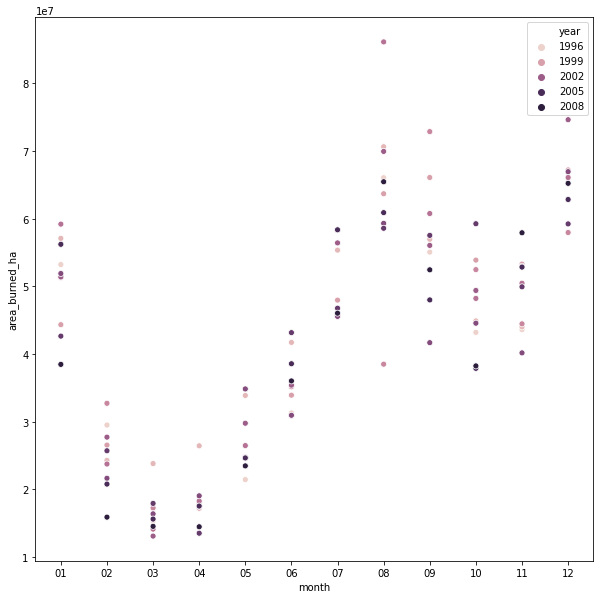

In [6]:
fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=burned_area_df, x='month', y='area_burned_ha', hue='year')
plt.show()

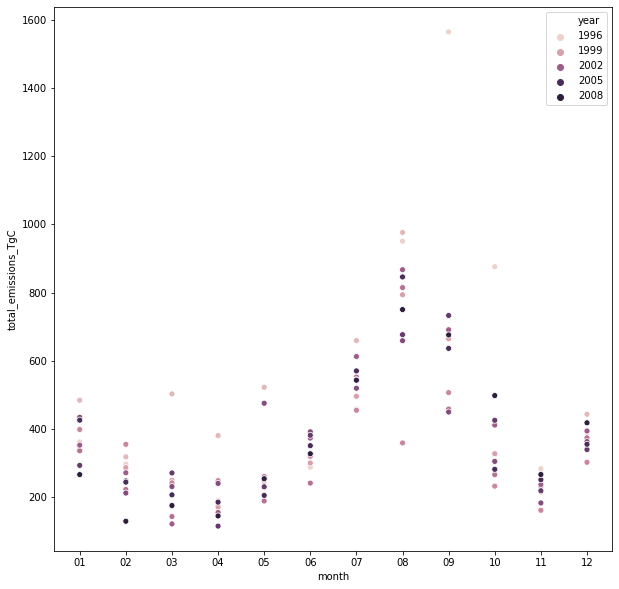

In [7]:
fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=burned_area_df, x='month', y='total_emissions_TgC', hue='year')
plt.show()

In [8]:
# Assume 500 trees/ha, each 1 ton = 1e6 g. 
trees_area = 500 # trees/ha
mass_tree = 1e6  # g
mass_g_ha = trees_area*mass_tree # g/ha
mass_Tg_ha = mass_g_ha*1e-12     # Tg/ha

# Annual emissions from forest fire.
mean_forest_emissions = burned_by_year.total_forest_emissions_TgC.mean()
inferred_ha = mean_forest_emissions / mass_Tg_ha
inferred_Mha = inferred_ha*1e-6
print('Inferred forest area burned/yr %.1g Mha' % inferred_Mha)

Inferred forest area burned/yr 0.9 Mha
